# Practica Bimestral Tercer Entragable


## Integrantes:

- Freddy Leon
- Miguel Álvarez
- Kevin Bustamante
- Pablo Ramón

<h1>Instalación de la Libreria</h1>



In [1]:
pip install pybliometrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install rdflib

Note: you may need to restart the kernel to use updated packages.


<h1>Importación de librerías necesarias</h1>

In [3]:
import pybliometrics
from pybliometrics.scopus import ScopusSearch, AbstractRetrieval
import pandas as pd
import re
import csv
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import RDF, XSD, DC


<h1>Incializar las configuraciones de pybliometrics</h1>

In [4]:
pybliometrics.scopus.init()


<h1>Función para buscar y transformar los resultados en un DataFrame</h1>

In [5]:
# Función para buscar y transformar los resultados en un DataFrame
def fetch_all_results_with_pybliometrics(query):
    search = ScopusSearch(query, view="COMPLETE", refresh=False, verbose=False)
    data = {
        "eid": [doc.eid for doc in search.results],
    }
    df = pd.DataFrame(data)
    return df


<h1>Función para extraer información detallada de caad articulo usando AbstractRetrieval(Articulos)</h1>

In [6]:
# Función para extraer información detallada usando AbstractRetrieval
def fetch_article_details(eids):
    detailed_data = []

    for eid in eids:
        try:
            # Obtiene información del artículo
            article = AbstractRetrieval(eid, view="FULL", refresh=False)

            # Asegúrate de que 'references' no sea None antes de intentar procesarlo
            references = "; ".join([ref[1] if ref[1] is not None else "No reference" for ref in article.references]) if article.references else "No references"

            # Asegúrate de que los autores no sean None antes de concatenarlos
            authors = "; ".join([f"{author.given_name} {author.surname}" for author in article.authors]) if article.authors else "No authors"
            authors_id = "; ".join([f"{author.auid}" for author in article.authors]) if article.authors else "No authors"

            # Extraer a las Universidades que se encuentra el artículo
            affiliation = "; ".join([f"{affiliation.name}" for affiliation in article.affiliation]) if article.affiliation else "No afiliación"
            ciudad = "; ".join([f"{ciudad.city}" for ciudad in article.affiliation]) if article.affiliation else "Sin Ciudad"

            # Asegúrate de que el país no sea None
            Country = "; ".join(sorted(set(pais.country for pais in article.affiliation if pais.country))) if article.affiliation else "No country"

            detailed_data.append({
                "eid": eid,
                "title": article.title,
                "doi": article.doi,
                "Pais": Country,
                "Ciudad": ciudad,
                "Universidad": affiliation,
                "publicationName": article.publicationName,
                "coverDate": article.coverDate,
                "authors": authors,
                "authorsId": authors_id,
                "references": references,
                "keywords": article.authkeywords or "No keywords",
                "abstract": article.abstract or "No abstract",
                "cited_by": article.citedby_count,
            })

        except Exception as e:
            print(f"Error procesando eid {eid}: {e}")

    return pd.DataFrame(detailed_data)

<h1>Aplicación de la primera función, mas al definición de la variable query(consulta)</h1>

In [7]:
query = "TITLE-ABS-KEY(energy) AND TITLE-ABS-KEY(Ecuador)"
df_results = fetch_all_results_with_pybliometrics(query)

<h1>Extración de informacion detallada usando el EID</h1>

In [8]:
df_detailed = fetch_article_details(df_results["eid"])



<h1>Guardar datos en un csv y limpiar la columna eid</h1>

In [9]:
df_detailed["eid"] = df_detailed["eid"].apply(lambda x: x.split("-")[-1] if isinstance(x, str) else x)

df_detailed.to_csv("scopus_detailed_results_article.csv", index=False, encoding="utf-8")

print(f"Se han recuperado detalles de {len(df_detailed)} artículos.")
print(df_detailed.head())


Se han recuperado detalles de 1504 artículos.
           eid                                              title  \
0  85210544686  Definition of a Typical Driving Cycle of an el...   
1  85207931922  Operational and embodied energy of residential...   
2  85210056804  Statistical evaluation of steel moment frames ...   
3  85208428732  Energy storage system for increasing electric-...   
4  85205798294  Assessing the chemical landscape of the Galápa...   

                                  doi                                Pais  \
0        10.17533/udea.redin.20240728                             Ecuador   
1       10.1016/j.enbuild.2024.114982                      Ecuador; Spain   
2          10.1016/j.jobe.2024.111395      Chile; Ecuador; United Kingdom   
3  10.11591/ijpeds.v15.i4.pp2517-2525                   Colombia; Ecuador   
4     10.1016/j.scitotenv.2024.176659  Australia; Ecuador; United Kingdom   

                                              Ciudad  \
0                   

<h1>Función para extraer los autores y sus IDs</h1>

In [10]:
def fetch_authors_with_ids(query):
    search = ScopusSearch(query, view="COMPLETE", refresh=False, verbose=False)

    # Extraer los autores y sus IDs
    authors_data = []
    for doc in search.results:
        if doc.author_ids and doc.author_names:
            # Separar los IDs y nombres de autores
            ids = doc.author_ids.split(";")
            names = doc.author_names.split(";")
            for author_id, author_name in zip(ids, names):
                authors_data.append({"author_id": author_id.strip(), "author_name": author_name.strip()})

    # Crear un DataFrame con los datos de autores
    df_authors = pd.DataFrame(authors_data)
    return df_authors.drop_duplicates()  # Eliminar duplicados


<h1>Función para Limpiar y Reformatear los Nombres de los Autorers</h1>

In [11]:
def clean_author_name(author_name):
    # Reorganizar si el formato es "Apellido, Nombre" a "Nombre Apellido"
    if "," in author_name:
        parts = author_name.split(",")
        if len(parts) == 2:
            # Construir el nombre en formato "Nombre Apellido"
            author_name = f"{parts[1].strip()} {parts[0].strip()}"

    # Reemplazar NBSP (\xa0) con un espacio normal
    author_name = author_name.replace("\xa0", " ")

    # Eliminar caracteres no deseados pero preservando espacios
    author_name = re.sub(r"[-]", " ", author_name)  # Eliminar guiones, preservar espacios

    return author_name


<h1>Aplicación de Funciones</h1>

In [12]:
df_authors = fetch_authors_with_ids(query)
df_authors['author_name'] = df_authors['author_name'].apply(clean_author_name)


<h1>Guardar en Csv y imprimir una lista del Dataframe</h1>

In [13]:
df_authors.to_csv("cleaned_authors_with_ids.csv", index=False, encoding="utf-8")

print(f"Se han limpiado y reformateado los nombres de {len(df_authors)} autores únicos.")
print(df_authors.head())


Se han limpiado y reformateado los nombres de 4689 autores únicos.
     author_id                        author_name
0  57223108364            Jairo Castillo Calderón
1  59446818600              Daniel Cordero Moreno
2  59447110500  Efrén Esteban Fernández Palomeque
3  57821862800   Byron Agustín Solórzano Castillo
4  59447206400      Pablo Rafael Jaramillo Merino


<h1>Función para extraer detalles de las Referencias</h1>

In [14]:
# Función para extraer información detallada usando AbstractRetrieval
def fetch_article_details(eids):
    detailed_data = []

    for eid in eids:
        try:
            # Obtiene información del artículo
            article = AbstractRetrieval(eid, view="FULL", refresh=False)

            if article.references:
                # Iterar sobre cada referencia y agregar una fila separada
                for ref in article.references:
                    # Aquí `ref[1]` es el `eid` de la referencia y `ref[2]` es el título de la referencia
                    referencia_eid = ref[1] if ref[1] is not None else None
                    referencia_titulo = ref[3] if ref[3] is not None else "No hay Titulo"
                    referencia_autor = ref[4] if ref[4] is not None else "Sin Autor"
                    referencia_year = ref[8] if ref[8] is not None else None
                    referencia_sorcetitle = ref[7] if ref[7] is not None else "Sin titulo"

                    # Agregar solo las referencias con sus valores
                    detailed_data.append({
                        "eid": referencia_eid,
                        "Titulo": referencia_titulo,
                        "Autor": referencia_autor,
                        "Año": referencia_year,
                        "Titulo de la Fuente": referencia_sorcetitle,
                    })

        except Exception as e:
            print(f"Error procesando eid {eid}: {e}")

    return pd.DataFrame(detailed_data)

<h1>Extraer Información, Eliminar Duplicados y Guardar resultados</h1>

In [15]:
# Extraer información detallada
df_detailed = fetch_article_details(df_results["eid"])

# Eliminar filas duplicadas (basado en las columnas 'eid')
df_detailed = df_detailed.drop_duplicates(subset=["eid"], keep="first")

# Guardar resultados en un archivo CSV
df_detailed.to_csv("referencias_detalles.csv", index=False, encoding="utf-8")

print(f"Se han recuperado detalles de {len(df_detailed)} referencias sin duplicados.")
print(df_detailed.head())

Se han recuperado detalles de 49568 referencias sin duplicados.
           eid                                             Titulo  \
0  85059320743  Usage pattern analysis of beijing private elec...   
1  84962138779  Large-scale deployment of electric taxis in be...   
2  85086123259         Storage technologies for electric vehicles   
3  84948844538  Driving cycle developments and their impacts o...   
4  85118829560  The effect of driving cycle duration on its re...   

                                               Autor   Año  \
0               Zhang, X.; Zou, Y.; Fan, J.; Guo, H.  2019   
1       Zou, Y.; Wei, S.; Sun, F.; Hu, X.; Shiao, Y.  2016   
2         Sharma, S.; Panwar, A. K.; Tripathi, M. M.  2020   
3                           Achour, H.; Olabi, A. G.  2016   
4  Giraldo, M.; Quirama, L. F.; Huertas, J. I.; T...  2021   

                     Titulo de la Fuente  
0                                 Energy  
1                                 Energy  
2  J. Traffic Trans

<h1>Definir los prefijos y namespaces</h1>

In [16]:
# Espacios de nombres
SCHEMA = Namespace("http://schema.org/")
EX = Namespace("http://example.com/")

<h1>Crear un grafo RDF</h1>

In [17]:
g = Graph()
g.bind("schema", SCHEMA)
g.bind("dc", DC)
g.bind("ex", EX)


In [18]:
# Cargar los autores y sus ids en un diccionario
authors_dict = {}
with open("cleaned_authors_with_ids.csv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        authors_dict[row["author_id"]] = row["author_name"]

# Cargar las referencias y asociarlas con su URI en un diccionario
references_dict = {}
with open("referencias_detalles.csv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ref_uri = URIRef(f"http://example.com/reference/{row['eid']}")
        references_dict[row['eid']] = ref_uri

# Cargar las referencias y asociarlas con sus detalles en un diccionario
references_dict = {}
with open("referencias_detalles.csv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ref_uri = URIRef(f"http://example.com/reference/{row['eid']}")
        references_dict[row['eid']] = {
            "uri": ref_uri,
            "title": row["Titulo"],
            "year": row["Año"],
            "source": row["Titulo de la Fuente"]
        }

# Ruta del archivo CSV de detalles de Scopus
csv_file = "scopus_detailed_results_article.csv"

<h1>Función para generar URI únicas</h1>

In [19]:
# Función para generar URI únicas
def generate_uri(identifier):
    return URIRef(f"http://example.com/paper/{identifier}")

<h1>Leer el archivo CSV y generar tripletas</h1>

In [20]:
# Cargar los datos de artículos
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        paper_uri = generate_uri(row["eid"])
        g.add((paper_uri, RDF.type, SCHEMA.ScholarlyArticle))
        g.add((paper_uri, SCHEMA.title, Literal(row["title"])))
        g.add((paper_uri, SCHEMA.datePublished, Literal(row["coverDate"])))
        g.add((paper_uri, SCHEMA.abstract, Literal(row["abstract"], lang="en")))
        g.add((paper_uri, SCHEMA.keywords, Literal(row["keywords"], lang="en")))
        
        # Asociar autores
        if row["authors"]:
            author_ids = row["authors"].split(";")  # Asumiendo que los IDs de autores están separados por ";"
            for author_id in author_ids:
                author_id = author_id.strip()
                author_uri = URIRef(f"http://example.com/author/{author_id.replace(' ','_')}")
                g.add((author_uri, RDF.type, SCHEMA.Person))
                g.add((author_uri, SCHEMA.name, Literal(author_id)))
                g.add((paper_uri, SCHEMA.author, author_uri))

        # Asociar referencias con detalles
        if row["references"]:
            ref_ids = row["references"].split(";")  # Asumiendo que las referencias están separadas por ";"
            for ref_id in ref_ids:
                ref_id = ref_id.strip()
                if ref_id in references_dict:
                    ref_data = references_dict[ref_id]
                    ref_uri = ref_data["uri"]
                    g.add((paper_uri, SCHEMA.citation, ref_uri))
                    # Agregar detalles de la referencia
                    g.add((ref_uri, RDF.type, SCHEMA.ScholarlyArticle))
                    g.add((ref_uri, SCHEMA.name, Literal(ref_data["title"])))         # Título de la referencia
                    g.add((ref_uri, SCHEMA.datePublished, Literal(ref_data["year"]))) # Año de publicación
                    g.add((ref_uri, SCHEMA.isPartOf, Literal(ref_data["source"])))    # Fuente de la publicación


        # Asociar países
        if row["Pais"]:
            countries = row["Pais"].split(";")  # Asumiendo que los países están separados por ";"
            for country in countries:
                country = country.strip()  # Eliminar espacios en blanco
                country_uri = URIRef(f"http://example.com/country/{country.replace(' ', '_')}")  # Generar URI para el país
                g.add((country_uri, RDF.type, SCHEMA.Country))
                g.add((country_uri, SCHEMA.name, Literal(country)))
                g.add((paper_uri, SCHEMA.locationCreated, country_uri))  # Relación entre artículo y país


<h1>Guardar el grafo en un archivo RDF (formato Turtle)</h1>

In [21]:
# Guardar el grafo en un archivo RDF (formato Turtle)
output_file = "Test1.ttl"
g.serialize(destination=output_file, format="turtle")



<Graph identifier=N3fb98eb69c0342329f0b7dbf246edbeb (<class 'rdflib.graph.Graph'>)>

<h1>Tripletas Generadas</h1>

In [22]:
# Mostrar la cantidad de triples generadas
triples_count = len(g)
print(f"Tripletas generadas: {triples_count}")
print(f"Tripletas guardadas en {output_file}")

Tripletas generadas: 24577
Tripletas guardadas en Test1.ttl


In [23]:
# Espacios de nombres
SCHEMA = Namespace("http://schema.org/")
EX = Namespace("http://example.com/")

g = Graph()
g.bind("schema", SCHEMA)
g.bind("dc", DC)
g.bind("ex", EX)

# Cargar los autores y sus ids en un diccionario
authors_dict = {}
with open("cleaned_authors_with_ids.csv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        authors_dict[row["author_id"]] = row["author_name"]

# Cargar las referencias y asociarlas con su URI en un diccionario
references_dict = {}
with open("referencias_detalles.csv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ref_uri = URIRef(f"http://example.com/reference/{row['eid']}")
        references_dict[row['eid']] = ref_uri

# Cargar las referencias y asociarlas con sus detalles en un diccionario
references_dict = {}
with open("referencias_detalles.csv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ref_uri = URIRef(f"http://example.com/reference/{row['eid']}")
        references_dict[row['eid']] = {
            "uri": ref_uri,
            "title": row["Titulo"],
            "year": row["Año"],
            "source": row["Titulo de la Fuente"]
        }

# Ruta del archivo CSV de detalles de Scopus
csv_file = "scopus_detailed_results_article.csv"

# Función para generar URI únicas
def generate_uri(identifier):
    return URIRef(f"http://example.com/paper/{identifier}")


# Cargar los datos de artículos
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        paper_uri = generate_uri(row["eid"])
        g.add((paper_uri, RDF.type, SCHEMA.ScholarlyArticle))
        g.add((paper_uri, SCHEMA.title, Literal(row["title"])))
        g.add((paper_uri, SCHEMA.datePublished, Literal(row["coverDate"])))
        g.add((paper_uri, SCHEMA.abstract, Literal(row["abstract"], lang="en")))
        g.add((paper_uri, SCHEMA.keywords, Literal(row["keywords"], lang="en")))
        
        # Asociar autores
        if row["authors"]:
            author_ids = row["authors"].split(";")  # Asumiendo que los IDs de autores están separados por ";"
            for author_id in author_ids:
                author_id = author_id.strip()
                author_uri = URIRef(f"http://example.com/author/{author_id.replace(' ','_')}")
                g.add((author_uri, RDF.type, SCHEMA.Person))
                g.add((author_uri, SCHEMA.name, Literal(author_id)))
                g.add((paper_uri, SCHEMA.author, author_uri))

        # Asociar referencias con detalles
        if row["references"]:
            ref_ids = row["references"].split(";")  # Asumiendo que las referencias están separadas por ";"
            for ref_id in ref_ids:
                ref_id = ref_id.strip()
                if ref_id in references_dict:
                    ref_data = references_dict[ref_id]
                    ref_uri = ref_data["uri"]
                    g.add((paper_uri, SCHEMA.citation, ref_uri))
                    # Agregar detalles de la referencia
                    g.add((ref_uri, RDF.type, SCHEMA.ScholarlyArticle))
                    g.add((ref_uri, SCHEMA.name, Literal(ref_data["title"])))         # Título de la referencia
                    g.add((ref_uri, SCHEMA.datePublished, Literal(ref_data["year"]))) # Año de publicación
                    g.add((ref_uri, SCHEMA.isPartOf, Literal(ref_data["source"])))    # Fuente de la publicación


        # Asociar países
        if row["Pais"]:
            countries = row["Pais"].split(";")  # Asumiendo que los países están separados por ";"
            for country in countries:
                country = country.strip()  # Eliminar espacios en blanco
                country_uri = URIRef(f"http://example.com/country/{country.replace(' ', '_')}")  # Generar URI para el país
                g.add((country_uri, RDF.type, SCHEMA.Country))
                g.add((country_uri, SCHEMA.name, Literal(country)))
                g.add((paper_uri, SCHEMA.locationCreated, country_uri))  # Relación entre artículo y país


# Guardar el grafo en un archivo RDF (formato Turtle)
output_file = "Pablo.ttl"
g.serialize(destination=output_file, format="turtle")



# Mostrar la cantidad de triples generadas
triples_count = len(g)
print(f"Tripletas generadas: {triples_count}")
print(f"Tripletas guardadas en {output_file}")

Tripletas generadas: 281691
Tripletas guardadas en Pablo.ttl


<h1>Grafo</h1>

Podemos ver los ids que son de cada articulo que fue extraido y cada uno de los ids celestes tiene ids rojos que son las referencias de ese articulo

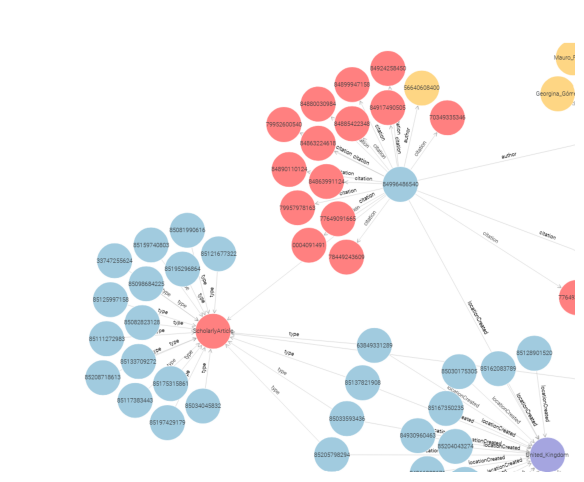

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('Grafo 3.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()


Aqui sale vuelta todos los articulos y los paises de los articulos

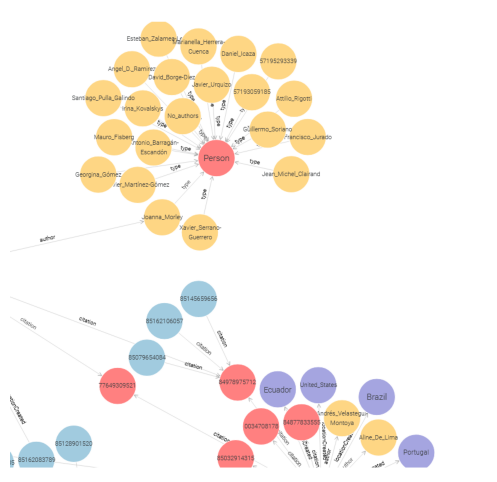

In [25]:
# Cargar la imagen
img = mpimg.imread('Grafo 4.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()


<h1>Plantear al menos 10 preguntas que aprovechen la estructura del grafo e implementar las consultas SPARQL que den solución a las preguntas.</h1>

* 1.Devuelva todos los autores que este en el grafo, presente el id y el nombre 

PREFIX schema: <http://schema.org/>

SELECT ?author ?author_name WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
}

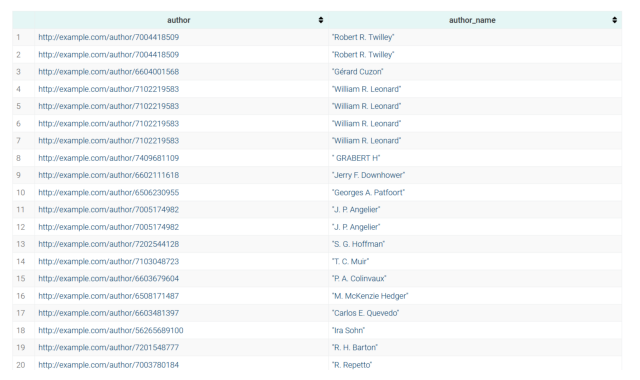

In [26]:
# Cargar la imagen
img = mpimg.imread('Consulta 1.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()


* 2.Devuelva los autores solo de este articulo ('85210056804') 

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper ?author_name WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
    FILTER(str(?paper) = "http://example.com/paper/85210056804")

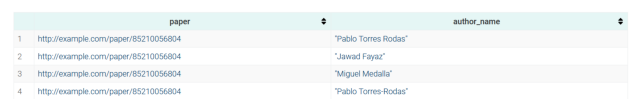

In [27]:
# Cargar la imagen
img = mpimg.imread('Consulta 2.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 3.Los Articulos en que es autor esta persona Jairo Castillo-Calderón


PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper ?paper_title WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
    FILTER(str(?author_name) = "Jairo Castillo-Calderón")
    
    ?paper schema:name ?paper_title .
    
}



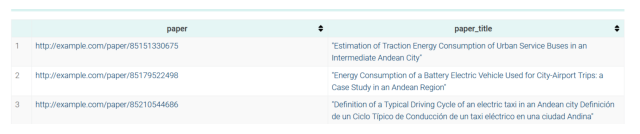

In [28]:
# Cargar la imagen
img = mpimg.imread('Consulta 3.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 4.Saca los id de otros articulos sobre este articulo ("85205600860")


PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?reference WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:citation ?reference .
    
    FILTER(str(?paper) = "http://example.com/paper/85205600860")  # Sustituye 12345 con el eid del artículo
    
}


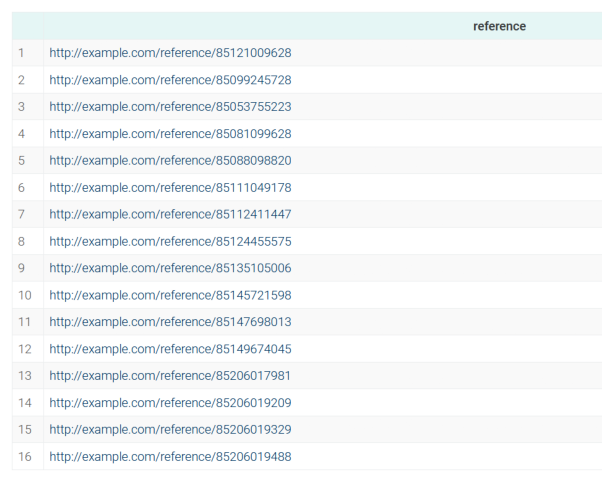

In [29]:
# Cargar la imagen
img = mpimg.imread('Consulta 4.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 5.Traer todos los paises asociados a los articulos


PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper ?country ?country_name WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:locationCreated ?country .
    
    ?country schema:name ?country_name .
    
}

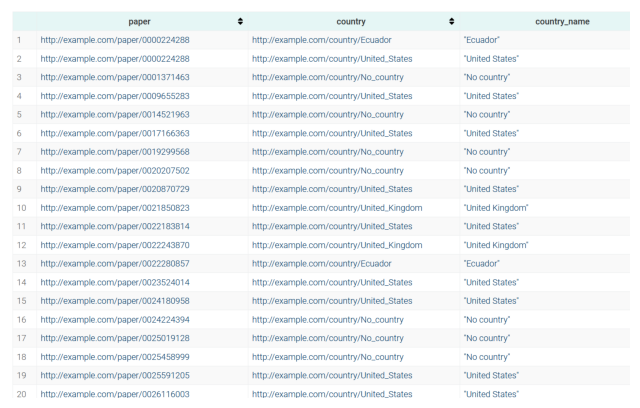

In [30]:
# Cargar la imagen
img = mpimg.imread('Consulta 5.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 6.Devuelva todos los artículos publicados en una fecha determinada.


PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper ?paper_title WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:datePublished ?date .
    
    ?paper schema:name ?paper_title .
    
    FILTER(?date = "2020-03-01")  # Sustituye con la fecha que deseas consultar
    
}

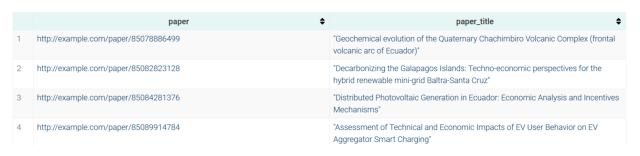

In [31]:
# Cargar la imagen
img = mpimg.imread('Consulta 6.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 7.Trae el articulo, el titulo, el id del autor y el nombre del autor

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper ?paper_title ?author ?author_name WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
    ?paper schema:name ?paper_title .
    
}

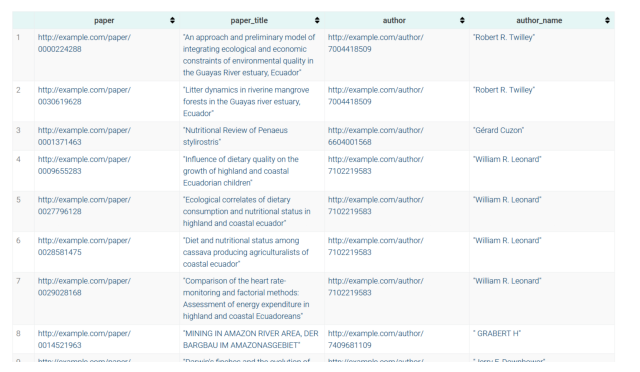

In [32]:
# Cargar la imagen
img = mpimg.imread('Consulta 7.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 8.Cuenta el numero de articulos que se encuentran en el Grafo

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT (COUNT(?paper) AS ?total_articles) WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
}

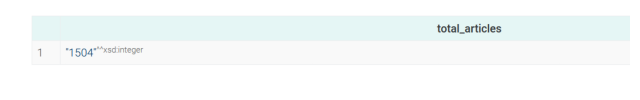

In [33]:
# Cargar la imagen
img = mpimg.imread('Consulta 8.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 9.Obtener los títulos de los artículos publicados después de una fecha específica

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?paper_title ?date_published WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:name ?paper_title .
    
    ?paper schema:datePublished ?date_published .
    
    FILTER(?date_published > "2021-01-01")
    
}

ORDER BY ?date_published

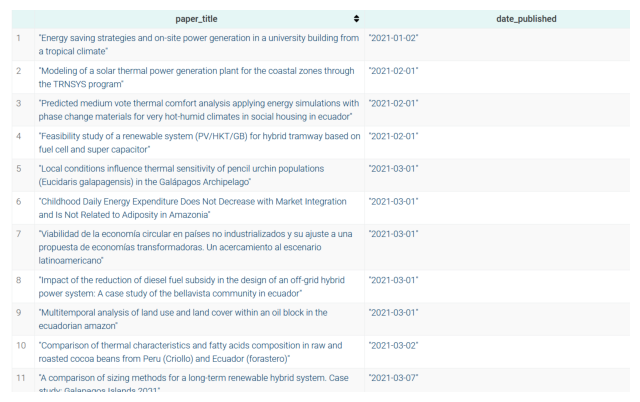

In [34]:
# Cargar la imagen
img = mpimg.imread('Consulta 9.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 10.Contar cuántos artículos están asociados con cada autor

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?author_name (COUNT(?paper) AS ?total_articles) WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
}

GROUP BY ?author_name

ORDER BY DESC(?total_articles)

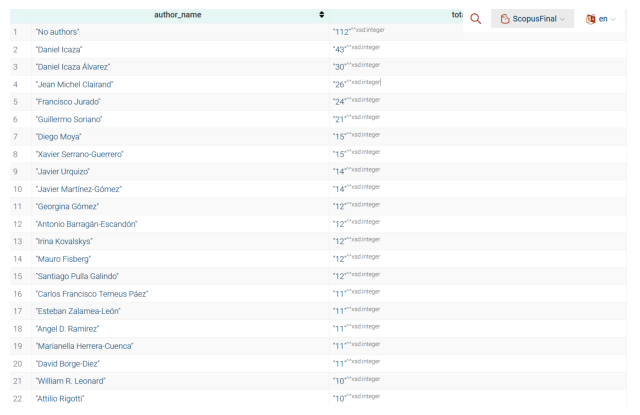

In [35]:
# Cargar la imagen
img = mpimg.imread('Consulta 10.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 11.Obtener los autores y títulos de artículos que mencionan un país específico

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper_title ?author_name ?country_name WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:name ?paper_title .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
    ?paper schema:locationCreated ?country .
    
    ?country schema:name ?country_name .
    
    FILTER(CONTAINS(LCASE(?country_name), "united states"))
    
}


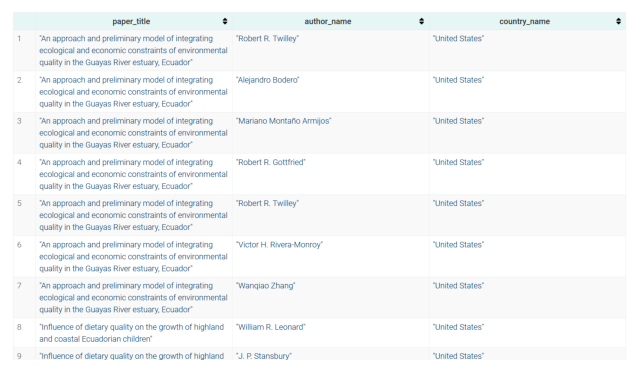

In [36]:
# Cargar la imagen
img = mpimg.imread('Consulta 11.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

* 12.Buscar artículos con mas de 20 autores y listar sus títulos y autores

PREFIX schema: <http://schema.org/>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper_title (GROUP_CONCAT(?author_name; separator=", ") AS ?authors) WHERE {

    ?paper rdf:type schema:ScholarlyArticle .
    
    ?paper schema:name ?paper_title .
    
    ?paper schema:author ?author .
    
    ?author schema:name ?author_name .
    
}
GROUP BY ?paper_title

HAVING (COUNT(?author) > 20)

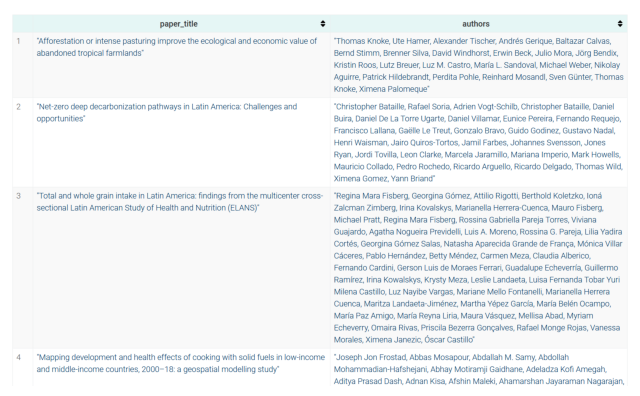

In [37]:
# Cargar la imagen
img = mpimg.imread('Consulta 12.png')  # Reemplaza con la ruta de tu imagen

# Mostrar la imagen
plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()